In [2]:
import pandas as pd
import numpy as np
import plotly
import matplotlib
import matplotlib.pyplot as plt
import qgrid
qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folder
import tqdm
from __future__ import division
import plotly.graph_objs as go
import plotly.plotly as py
plotly.tools.set_credentials_file(username='pashna480f', api_key='ujbSRP9M7kcs0icU92lF')
from IPython.display import display
import os
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [3]:
import seaborn as sns
sns.set()

In [4]:
import time
from datetime import datetime
def get_timestamp(s):
    date = "2017-10-10 " + s[13:21]
    timestamp = datetime.strptime("2017-10-10 " + s, "%Y-%m-%d %H:%M:%S.%f").timetuple()
    timestamp = time.mktime(timestamp)
    ms = int(s[9:])
    timestamp *= 1000
    
    timestamp += ms
    
    return timestamp

In [5]:
def read_df(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df['time'] = df[1].apply(lambda s: s[13:25])
    df['timestamp'] = df['time'].apply(lambda s: get_timestamp(s))

    df.rename(columns= {
        2: 'ip_src',
        3: 'ip_dst',
        4: 'size'
    }, inplace = True)

    del df[0]
    del df[1]
    del df[5]
    df.dropna(inplace=True)

    return df

In [6]:
def aggregate_by(df, agg_by=500):
    df = df.copy()
    min_time = df['timestamp'].min()
    df['timestamp'] = df['timestamp'] - min_time
    
    df['agg_group'] = df['timestamp'] / agg_by
    df['agg_group'] = df['agg_group'].round(0).astype(int)
    
    df_grouped = df.groupby('agg_group')[['size']].sum()
    df_grouped = df_grouped.sort_index()
    
    df_grouped.reset_index(inplace=True)
    df_grouped.columns = ['time', 'size']
    df_grouped['time'] = df_grouped['time'] * agg_by / 1000
    
    all_values = pd.Series(np.arange(0, np.max(df_grouped['time']), agg_by/1000))
    
    return df_grouped

In [7]:
exp = {
    1: "capture/date__12_16_15_11mb_50.csv",
    0.5: "capture/date__12_16_15_12mb_50.csv",
    #0.2: "capture/date__12_16_14_50mb_2.csv",
    0.1: "capture/date__12_16_15_22mb_50.csv"
}

In [8]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [9]:
def add_missing_values(sizes, times, agg_by):
    all_times = np.arange(np.min(times), 
                      np.max(times), 
                      agg_by/1000)
    j = 0
    all_sizes = []
    for i in range(len(all_times)):

        if np.abs((all_times[i] - times[j])) < 0.000001:
            all_sizes.append(sizes[j])
            j += 1

        else:
            all_sizes.append(0)
            
    return np.asarray(all_sizes), np.asarray(all_times)

In [10]:
def get_time_size(df, agg_by, start_size = 0, ma = 0, size_norm = 1024*1024):
    agg = aggregate_by(df, agg_by)
    
    sizes, times = agg['size'].values, agg['time'].values
    sizes, times = add_missing_values(sizes, times, agg_by)
    
    if ma > 0:
        sizes = runningMeanFast(sizes, ma)
        
    if start_size > 0:
        first_index = next(x[0] for x in enumerate(sizes) if x[1] > start_size)
        times = times[first_index:]
        sizes = sizes[first_index:]
    
    time_min = np.min(times)
    times -= time_min
    sizes = sizes / size_norm 
    
    return sizes, times

In [11]:
import os
def get_sizes(home, agg_by=200, start_size=10*1000, ma=0, ip_src=None, ip_dst=None):
    """
    aggregates values from different experimet
    """
    pathes_to_file = [home + f for f in os.listdir(home) if '.csv' in f]
    
    agg_time_sizes = {}
    
    for f in pathes_to_file:
        df = read_df(f)
        print(f)
        if ip_src is not None and ip_dst is not None:
            df = df[(df['ip_src'] == ip_src) &
                    (df['ip_dst'] == ip_dst)]
            
        flow_sizes, flow_times = get_time_size(df, agg_by, start_size=start_size, ma=ma)

        N_SCALE = 0
        for i in range(len(flow_sizes)):
            time_interval = round(flow_times[i], 2)
            if time_interval in agg_time_sizes:
                agg_time_sizes[time_interval].append(flow_sizes[i])
            else:
                agg_time_sizes[time_interval] = [flow_sizes[i]]
    
    return agg_time_sizes

In [12]:
def get_mean_std(agg_time_size):
    times = []
    means = []
    stds = []
    
    for time_interval, sizes in agg_time_size.iteritems():
        means.append(np.mean(sizes))
        stds.append(np.std(sizes))
        times.append(time_interval)

    means = np.asarray(means)
    stds = np.asarray(stds)
    times = np.asarray(times)
    
    times_args = np.argsort(times)

    means = means[times_args]
    stds = stds[times_args]
    times = times[times_args]
    
    return times, means, stds

/home/newuser/MSU/capture/exp_1/1/date__12_16_16_16mb_50.csv
/home/newuser/MSU/capture/exp_1/1/date__12_16_16_11mb_50.csv
/home/newuser/MSU/capture/exp_1/1/date__12_16_16_12mb_50.csv
/home/newuser/MSU/capture/exp_1/1/date__12_16_16_14mb_50.csv
/home/newuser/MSU/capture/exp_1/1/date__12_16_16_17mb_50.csv
/home/newuser/MSU/capture/exp_1/1/date__12_16_20_46mb_50.csv
(1, 0.58814203127836562, 30.583385626475014, 15.300000000000001)
/home/newuser/MSU/capture/exp_1/0_5/date__12_16_16_39mb_50.csv
/home/newuser/MSU/capture/exp_1/0_5/date__12_16_16_27mb_50.csv
/home/newuser/MSU/capture/exp_1/0_5/date__12_16_20_43mb_50.csv
/home/newuser/MSU/capture/exp_1/0_5/date__12_16_20_40mb_50.csv
/home/newuser/MSU/capture/exp_1/0_5/date__12_16_16_38mb_50.csv
(0.5, 0.64569831245823917, 61.341339683532716, 15.1)
/home/newuser/MSU/capture/exp_1/0_2/date__12_16_17_05mb_50.csv
/home/newuser/MSU/capture/exp_1/0_2/date__12_16_17_16mb_50.csv
/home/newuser/MSU/capture/exp_1/0_2/date__12_16_17_10mb_50.csv
/home/newuse

[]

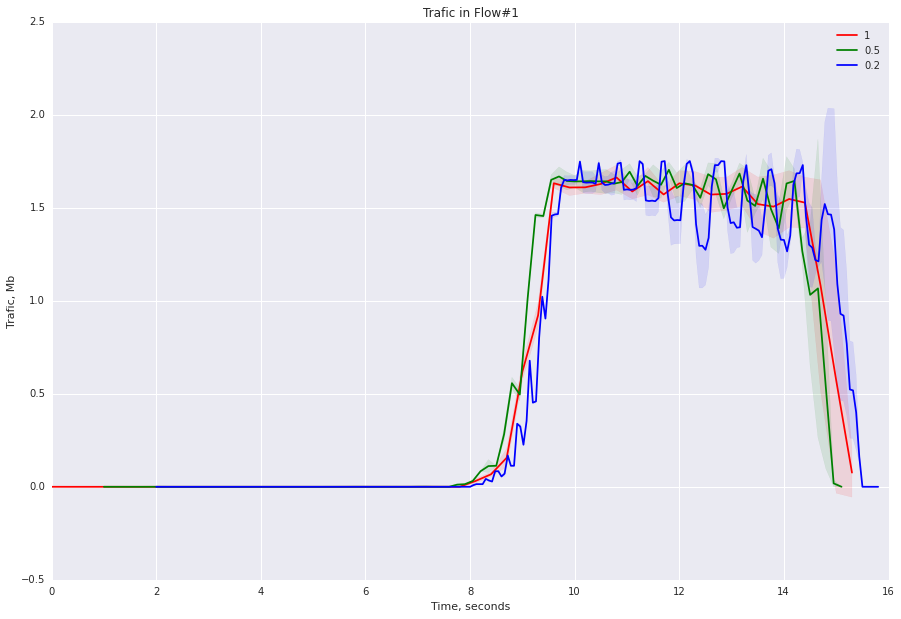

In [ ]:
scales = [1, 0.5, 0.2]

capture_folder = '/home/newuser/MSU/capture/exp_1/'
colors = ['r', 'g', 'b', 'y', 'p']

bias = [0,1,2]
mas = [0, 5, 5]

ip_src='10.0.0.1'
ip_dst='10.0.0.2'
plt.figure(figsize=(15, 10))
for i in range(len(scales)):
    scale = scales[i]
    
    folder = str(scale).replace('.', '_')
    exp_folder = capture_folder + folder + '/'

    agg_time_sizes = get_sizes(exp_folder, 
                      agg_by=300,
                      ma=int(1/scale), 
                      start_size = 0,
                      ip_src=ip_src,
                      ip_dst=ip_dst,
                    )
    times, mean, std = get_mean_std(agg_time_sizes)
    mean = mean / scale
    std = std / scale
    times = times * scale + bias[i]
    
    print(scale, np.nanmean(mean), np.nansum(mean), np.max(times))
    
    plt.plot(times, mean, label=scale, color=colors[i])
    plt.fill_between(times, (mean-std),(mean+std), alpha=0.1,color=colors[i])
    
plt.xlabel('Time, seconds')
plt.ylabel('Trafic, Mb')
plt.title("Trafic in Flow#1")
#plt.xlim(0, 20)
plt.legend()
plt.plot()